# Convolutional neural networks

The goal of this exercise is to train a convolutional neural network on MNIST and better understand what is happening during training.

## Training a CNN on MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print(tf.__version__)

2.3.0


**Tip:** CNNs are much slower to train on CPU than the DNN of the last exercise. It is feasible to do this exercise on a normal computer, but if you have a Google account, we suggest to use `colab` to run this notebook on a GPU **for free** (training time should be divided by a factor 5 or so). 

Go then in the menu, "Runtime" and "Change Runtime type". You can then change the "Hardware accelerator" to GPU. Do not choose TPU, it will be as slow as CPU for the small networks we are using.

We import and normalize the MNIST data like last time, except we do not reshape the images: they stay with the shape (28, 28, 1):

In [2]:
# Fetch the MNIST data
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()
print("Training data:", X_train.shape, t_train.shape)
print("Test data:", X_test.shape, t_test.shape)

# Normalize the values
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

# Mean removal
X_mean = np.mean(X_train, axis=0)
X_train -= X_mean
X_test -= X_mean

# One-hot encoding
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)


We can now define the CNN defined in the first image:

* a convolutional layer with 16 3x3 filters, using valid padding and ReLU transfer functions,
* a max-pooling layer over 2x2 regions,
* a fully-connected layer with 100 ReLU neurons,
* a softmax layer with 10 neurons.

The CNN will be trained on MNIST using SGD with momentum.

The following code defines this basic network in keras:

In [3]:
# Delete all previous models to free memory
tf.keras.backend.clear_session()

# Sequential model
model = tf.keras.models.Sequential()

# Input layer representing the (28, 28) image
model.add(tf.keras.layers.Input(shape=(28, 28, 1)))

# Convolutional layer with 16 feature maps using 3x3 filters
model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='valid'))
model.add(tf.keras.layers.Activation('relu')) 

# Max-pooling layerover 2x2 regions
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps into a vector
model.add(tf.keras.layers.Flatten())

# Fully-connected layer
model.add(tf.keras.layers.Dense(units=100))
model.add(tf.keras.layers.Activation('relu')) 

# Softmax output layer over 10 classes
model.add(tf.keras.layers.Dense(units=10))
model.add(tf.keras.layers.Activation('softmax')) 

# Learning rule
optimizer = tf.keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

# Loss function
model.compile(
    loss='categorical_crossentropy', # loss function
    optimizer=optimizer, # learning rule
    metrics=['accuracy'] # show accuracy
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               270500    
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Note the use of `Flatten()` to transform the 13x13x16 tensor representing the max-pooling layer into a vector of 2704 elements.

Note also the use of `padding='valid'` and its effect on the size of the tensor corresponding to the convolutional layer. Change it to `padding='same'` and conclude on its effect.

**Q:** Which layer has the most parameters? Why? Compare with the fully-connected MLPs you obtained during exercise 5.

**A:** conv layers have relatively few parameters (10 per filter). The main bottleneck is when going from convolutions to fully-connected.

Let's now train this network on MNIST for 10 epochs, using minibatches of 64 images:

In [4]:
# History tracks the evolution of the metrics during learning
history = tf.keras.callbacks.History()

# Training procedure
model.fit(
    X_train, T_train, # training data
    batch_size=64,  # batch size
    epochs=10, # Maximum number of epochs
    validation_split=0.1, # Perceptage of training data used for validation
    callbacks=[history] # Track the metrics at the end of each epoch
)

Epoch 1/10
844/844 [==============================] - 4s 5ms/step - loss: 0.1531 - accuracy: 0.9534 - val_loss: 0.0591 - val_accuracy: 0.9847
Epoch 2/10
844/844 [==============================] - 4s 5ms/step - loss: 0.0515 - accuracy: 0.9845 - val_loss: 0.0634 - val_accuracy: 0.9825
Epoch 3/10
844/844 [==============================] - 4s 5ms/step - loss: 0.0320 - accuracy: 0.9899 - val_loss: 0.0637 - val_accuracy: 0.9855
Epoch 4/10
844/844 [==============================] - 4s 5ms/step - loss: 0.0245 - accuracy: 0.9916 - val_loss: 0.0675 - val_accuracy: 0.9858
Epoch 5/10
844/844 [==============================] - 4s 5ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.0645 - val_accuracy: 0.9867
Epoch 6/10
844/844 [==============================] - 4s 5ms/step - loss: 0.0123 - accuracy: 0.9956 - val_loss: 0.0803 - val_accuracy: 0.9848
Epoch 7/10
844/844 [==============================] - 4s 5ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.0652 - val_accuracy: 0.9855
Epoch 

As in the previous exercise, the next cells compute the test loss and accuracy and display the evolution of the training and validation accuracies:

In [5]:
score = model.evaluate(X_test, T_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06909506767988205
Test accuracy: 0.9879999756813049


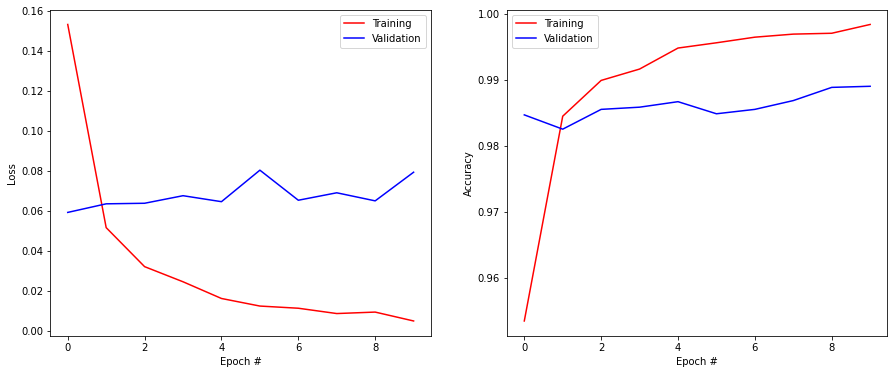

In [6]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Q:** What do you think of 1) the final accuracy and 2) the training time, compared to the MLP of last time?

**Q:** When does your network start to overfit? How to recognize it?

**Q:** Try different values for the batch size (16, 32, 64, 128..). What is its influence?

**A:** A CNN, even as shallow as this one, is more accurate but much slower (on CPU) than fully-connected networks. A network overfits when the training accuracy becomes better than the validation accuracy (learning by heart, not generalizing), which is the case here. When the batch size is too small, learning is unstable: the training loss increases again after a while. 128 is actually slightly better than 64.

**Q:** Improve the CNN to avoid overfitting. The test accuracy should be around 99%.

You can:

* change the learning rate
* add another block on convolution + max-pooling before the fully-connected layer to reduce the number of parameters,
* add dropout after some of the layers,
* use L2 regularization,
* use a different optimizer,
* do whatever you want.

**Beware:** training is now relatively slow, keep your number of tries limited. Once you find a good architecture that does not overfit, train it for 20 epochs and proceed to the next questions.

In [7]:
# Delete all previous models to free memory
tf.keras.backend.clear_session()

# Sequential model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input((28, 28, 1)))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(150, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Learning rule
optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Loss function
model.compile(
    loss='categorical_crossentropy', # loss
    optimizer=optimizer, # learning rule
    metrics=['accuracy'] # show accuracy
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

In [8]:
history = tf.keras.callbacks.History()

model.fit(
    X_train, T_train,
    batch_size=64, 
    epochs=20,
    validation_split=0.1,
    callbacks=[history]
)

Epoch 1/20
844/844 [==============================] - 7s 8ms/step - loss: 0.5681 - accuracy: 0.8124 - val_loss: 0.0961 - val_accuracy: 0.9713
Epoch 2/20
844/844 [==============================] - 6s 7ms/step - loss: 0.2027 - accuracy: 0.9374 - val_loss: 0.0715 - val_accuracy: 0.9788
Epoch 3/20
844/844 [==============================] - 6s 7ms/step - loss: 0.1563 - accuracy: 0.9511 - val_loss: 0.0585 - val_accuracy: 0.9833
Epoch 4/20
844/844 [==============================] - 6s 7ms/step - loss: 0.1355 - accuracy: 0.9586 - val_loss: 0.0499 - val_accuracy: 0.9855
Epoch 5/20
844/844 [==============================] - 6s 7ms/step - loss: 0.1233 - accuracy: 0.9625 - val_loss: 0.0448 - val_accuracy: 0.9868
Epoch 6/20
844/844 [==============================] - 6s 7ms/step - loss: 0.1100 - accuracy: 0.9656 - val_loss: 0.0424 - val_accuracy: 0.9867
Epoch 7/20
844/844 [==============================] - 6s 7ms/step - loss: 0.1028 - accuracy: 0.9679 - val_loss: 0.0407 - val_accuracy: 0.9885
Epoch 

In [9]:
score = model.evaluate(X_test, T_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.023560011759400368
Test accuracy: 0.9922000169754028


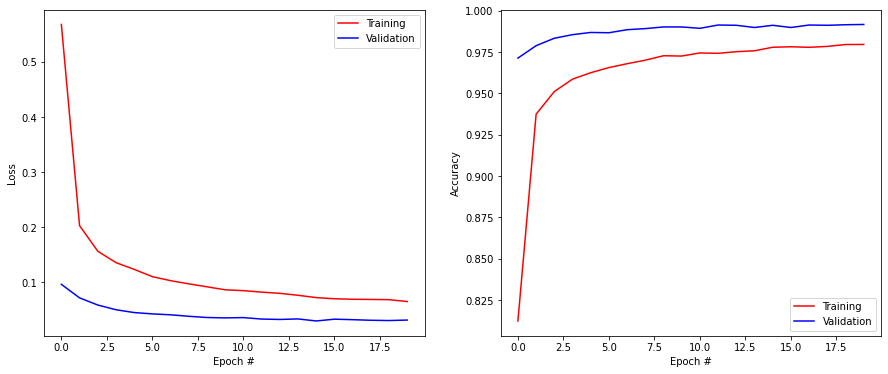

In [10]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Analysing the CNN

Once a network has been trained, let's see what has happened internally.

### Accessing trained weights

Each layer of the network can be addressed individually. For example, `model.layers[0]` represents the first layer of your network (the first convolutional one, as the input layer does not count). The index of the other layers can be found by looking at the output of `model.summary()`.

You can obtain the parameters of each layer (if any) with:

```python
W = model.layers[0].get_weights()[0]
```

**Q:** Print the shape of these weights and relate them to the network.

In [11]:
W = model.layers[0].get_weights()[0]
print("W shape : ", W.shape)

W shape :  (3, 3, 1, 32)


**Q:** Visualize with `imshow()` each of the 16 filters of the first convolutional layer. Interpret what kind of operation they perform on the image.

*Hint:* `subplot()` is going to be useful here. If you have 16 images `img[i]`, you can visualize them in a 4x4 grid with:

```python
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(img[i], cmap=plt.cm.gray)
```

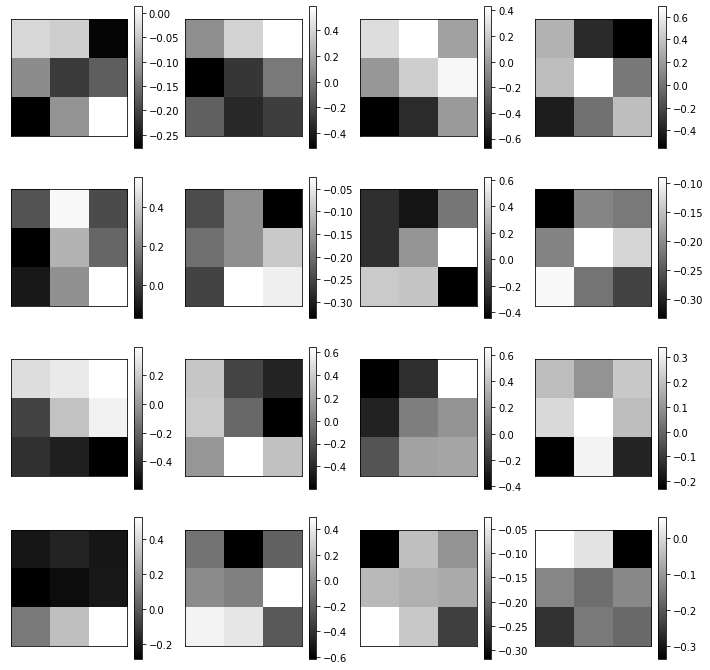

In [12]:
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(W[:, :, 0, i], cmap=plt.cm.gray)
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
plt.show()

### Visualizing the feature maps

Let's take a random image from the training set and visualize it: 

1


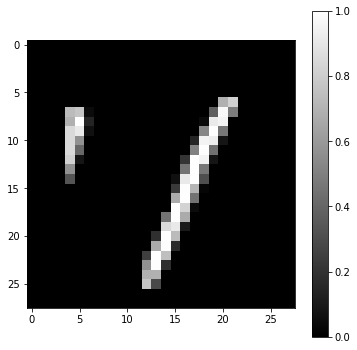

In [13]:
idx = 31727 # or any other digit
x = X_train[idx, :, :, :].reshape(1, 28, 28, 1)
t = t_train[idx]

print(t)

plt.figure(figsize=(6, 6))
plt.imshow(x[0, :, :, 0] + X_mean[:, :, 0], cmap=plt.cm.gray)
plt.colorbar()
plt.show()

This example could be a 1 or 7. That is why you will never get 100% accuracy on MNIST: some examples are hard even for humans...

**Q:** Print what the model predict for it, its true label, and visualize the probabilities in the softmax output layer (look at the doc of `model.predict()`):

Predicted digit: 1 ; True digit: 1


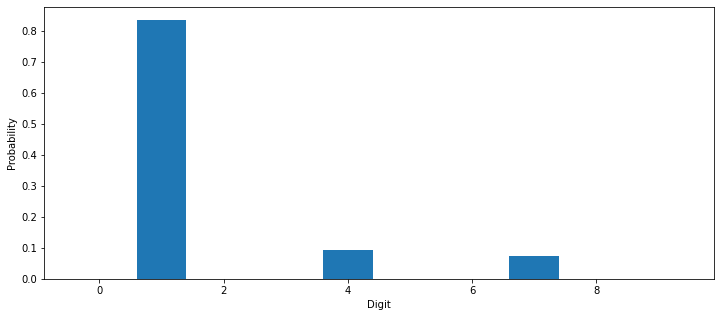

In [14]:
# Predict probabilities
output = model.predict([x])

# The predicted class has the maximal probability
prediction = output[0].argmax()
print('Predicted digit:', prediction, '; True digit:', t)

plt.figure(figsize=(12, 5))
plt.bar(range(10), output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.show()

Depending on how your network converged, you may have the correct prediction or not. 

**Q:** Visualize the output of the network for different examples. Do these ambiguities happen often?

Now let's look inside the network. We will first visualize the 16 feature maps of the first convolutional layer.

This is actually very simple using tensorflow 2.x: One only needs to create a new model (class `tf.keras.models.Model`, not Sequential) taking the same inputs as the original model, but returning the output of the first layer (`model.layers[0]` is the first convolutional layer of the model, as the input layer does not count):

```python
model_conv = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[0].output)
```

To get the tensor corresponding to the first convolutional layer, one simply needs to call `predict()` on the new model:

```python
feature_maps = model_conv.predict([x])
```

**Q:** Visualize the 16 feature maps using `subplot()`. Relate these activation with the filters you have visualized previously.

(1, 26, 26, 32)


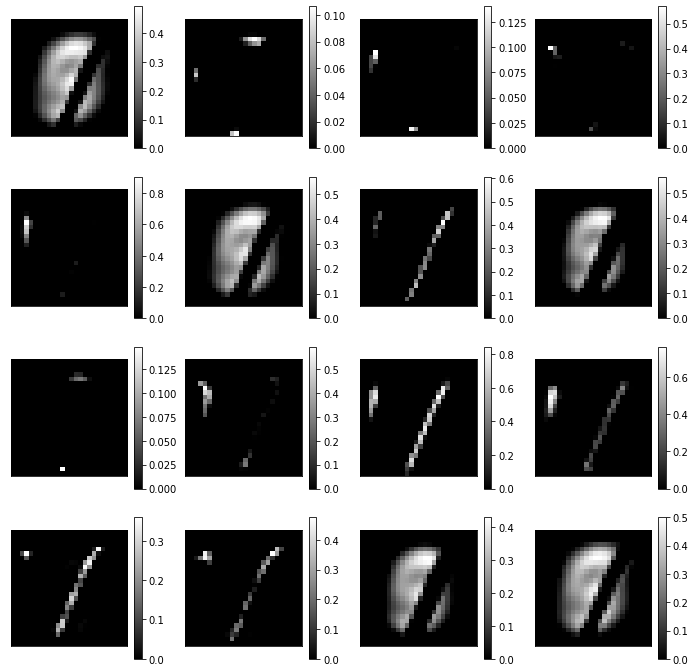

In [15]:
model_conv = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[0].output)

feature_maps = model_conv.predict([x])
print(feature_maps.shape)

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(feature_maps[0, :, :, i], cmap=plt.cm.gray)
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
plt.show()

**Q:** Do the same with the output of the first max-pooling layer.

*Hint:* you need to find the index of that layer in `model.summary()`.

(1, 13, 13, 32)


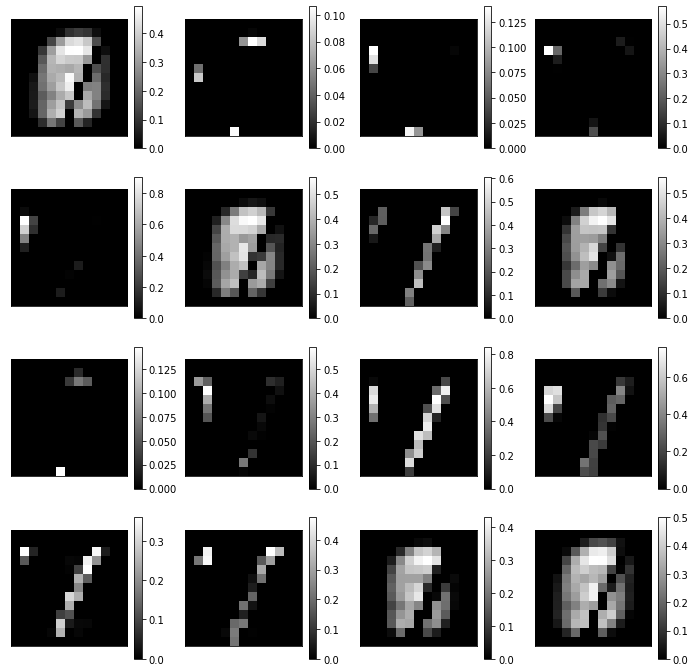

In [16]:
model_pool = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[1].output)

pooling_maps = model_pool.predict([x])
print(pooling_maps.shape)

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(pooling_maps[0, :, :, i], cmap=plt.cm.gray)
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
plt.show()

**Bonus question:** if you had several convolutional layers in your network, visualize them too. What do you think of the specificity of some features?

(1, 11, 11, 64)


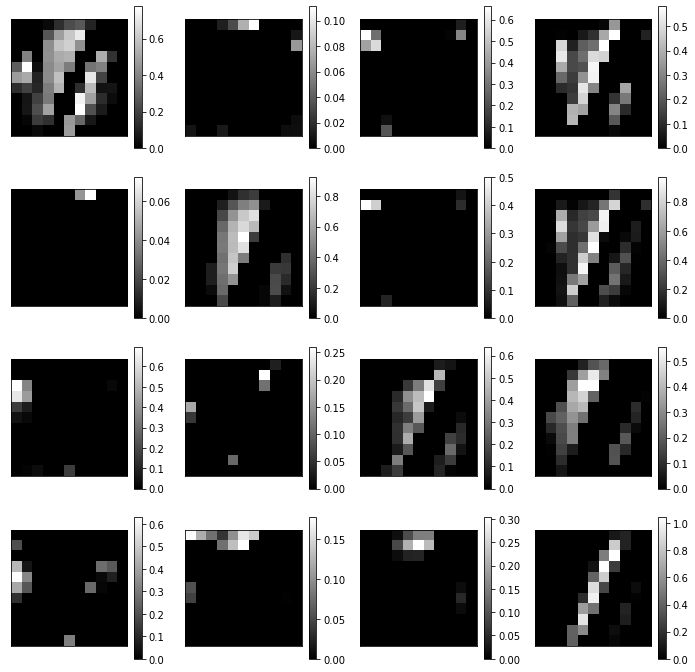

In [17]:
model_conv = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[3].output)

feature_maps = model_conv.predict([x])
print(feature_maps.shape)

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(feature_maps[0, :, :, i], cmap=plt.cm.gray)
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
plt.show()